# Script to test the combined model with result visualization

Created on Tue Jul 18 15:35:49 2023

@author: Juan Miguel Serrano

If using MATLAB code, see how to install the package in "Ejecución modelo MED v1.md"

and in linux before running this code need to export LD_LIBRARY_PATH:

    `export MR=$HOME/PSA/MED_model`
    `export LD_LIBRARY_PATH=$MR/v911/runtime/glnxa64:$MR/v911/bin/glnxa64:$MR/v911/sys/os/glnxa64:$MR/v911/sys/opengl/lib/glnxa64`

In [1]:
# MATLAB model
import os
os.environ["MR"] = f"{os.environ['HOME']}/PSA/MATLAB_runtime"
MR = os.environ["MR"]
os.environ["LD_LIBRARY_PATH"] = f"{MR}/v911/runtime/glnxa64:{MR}/v911/bin/glnxa64:{MR}/v911/sys/os/glnxa64:{MR}/v911/sys/opengl/lib/glnxa64"

# print(os.environ["MR"])
# print(os.environ["LD_LIBRARY_PATH"])

import pandas as pd
import numpy as np
import time
from utils import generate_env_variables
from utils.constants import vars_info

from models import med_storage_model

# Result visualization
import plotly.graph_objs as go
from plotly_resampler.figure_resampler import FigureWidgetResampler
from plotly.subplots import make_subplots

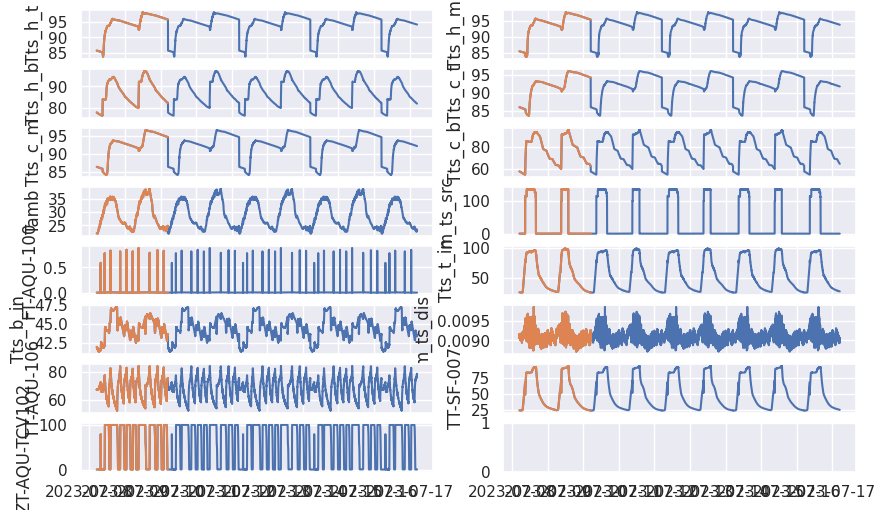

In [2]:
# Environment variables
total_time = pd.Timedelta(days=9) # Duration of the simulation
ts = 30 # Sample rate (seg)
L = int( total_time.total_seconds()/ts )

# Source: https://www.seatemperature.org/mediterranean-sea
mediterranean_sea_mean_temp_malaga = [16, 15, 15, 16, 17, 20, 22, 23, 22, 20, 18, 16] # ºC

env_vars_timeseries = generate_env_variables('datos/base_environment_data.csv', sample_period=total_time, sample_rate=ts)

Tts_t_in = env_vars_timeseries.Tts_t_in.values # ºC
Tamb = env_vars_timeseries.Tamb.values # ºC
mts_src = env_vars_timeseries.m_ts_src.values # L/min
Tmed_c_in = np.ones(L)*mediterranean_sea_mean_temp_malaga[7] # Hulio, ºC
wmed_f = np.ones(L)*35.5 # g/kg

# Thermal storage initial conditions
Tts_h = [83.95, 83.67, 75.99] 
Tts_c = [83.40, 83.50, 54.42]

# Decision variables should be updated/generated at every step, but to test 
# just create some series
mmed_s_sp     = 12*3.6 * np.ones(L)
mmed_f_sp     = 8  * np.ones(L)
Tmed_s_in_sp  = 65 * np.ones(L)
Tmed_c_out_sp = 28 * np.ones(L)

In [3]:
# Initialize combined system model
model = med_storage_model(
    ts=ts,
    curve_fits_path='datos/curve_fits.json',
    # Initial states. Thermal storage
    Tts_h=Tts_h, Tts_c=Tts_c,
)

In [4]:
# Run simulation
results = []
for idx in range(1, L):
    start_time = time.time()
    
    model.step(
        # Decision variables
        Tmed_s_in=float(Tmed_s_in_sp[idx]),
        Tmed_c_out=Tmed_c_out_sp[idx],
        mmed_s=float(mmed_s_sp[idx]),
        mmed_f=mmed_f_sp[idx],
        
        # Environment variables
        Tamb=Tamb[idx],
        Tmed_c_in=Tmed_c_in[idx],
        wmed_f=wmed_f[idx],
        
        mts_src=mts_src[idx],
        Tts_t_in=Tts_t_in[idx]
        )
    
    print(f'Iteration {idx} of {L} completed, took {time.time() - start_time:.3f} seconds')
    
    # Store system states
    results.append( model.get_properties() )

# Terminate 
model.terminate()

Iteration 1 of 25920 completed, took 1.185 seconds
Iteration 2 of 25920 completed, took 0.198 seconds
Iteration 3 of 25920 completed, took 0.037 seconds
Iteration 4 of 25920 completed, took 0.037 seconds
Iteration 5 of 25920 completed, took 0.040 seconds
Iteration 6 of 25920 completed, took 0.032 seconds
Iteration 7 of 25920 completed, took 0.034 seconds
Iteration 8 of 25920 completed, took 0.031 seconds
Iteration 9 of 25920 completed, took 0.033 seconds
Iteration 10 of 25920 completed, took 0.036 seconds
Iteration 11 of 25920 completed, took 0.037 seconds
Iteration 12 of 25920 completed, took 0.034 seconds
Iteration 13 of 25920 completed, took 0.034 seconds
Iteration 14 of 25920 completed, took 0.035 seconds
Iteration 15 of 25920 completed, took 0.036 seconds
Iteration 16 of 25920 completed, took 0.035 seconds
Iteration 17 of 25920 completed, took 0.033 seconds
Iteration 18 of 25920 completed, took 0.032 seconds
Iteration 19 of 25920 completed, took 0.033 seconds
Iteration 20 of 25920

ValueError: Value of Tts_h_t (64.55300531671372) must be greater than Tmed,s,in (65.0)

## Results visualization

Based on [plotly resampler example](examples/figurewidget_example.ipynb)

In [5]:
from utils.constants import colors
from utils.constants import vars_info, colors_gnome

v = vars_info

In [6]:
# Create time variable and extract results as a dataframe

x = env_vars_timeseries.index[1:len(results)+1].values
results_df = pd.DataFrame(results, index=x)

# Separate the columns of Tts_h into separate variables
for tank in ['h','c']:
    for idx, position in enumerate(['t','m','b']):
        results_df[f'Tts_{tank}_{position}'] = results_df[f'Tts_{tank}'].apply(lambda x: x[idx])
        
# Calculate energy stored over time in the thermal storage


In [7]:
r = results_df

custom_data = np.stack((
    # Decision variables
    r['Tmed_s_in'].values, 
    r['Tmed_c_out'].values,
    r['mmed_s'].values,
    r['mmed_f'].values,
    
    # Environment variables
    r['Tamb'].values,
    r['Tmed_c_in'].values,
    r['wmed_f'].values,
    r['Tts_t_in'].values,
    r['mts_src'].values,    
), axis=-1)

In [8]:
# Build hover text

hover_text = f"""
%{{x}}<br>
%{{meta[0]}}: %{{y:.2f}}<br><br>

<b>Decision variables</b><br>
- {v['Tmed_s_in']['label']}: %{{customdata[0]:.1f}} {v['Tmed_s_in']['unit_cs']}<br>
- {v['Tmed_c_out']['label']}: %{{customdata[1]:.1f}} {v['Tmed_c_out']['unit_cs']}<br>
- {v['mmed_s']['label']}: %{{customdata[2]:.1f}} {v['mmed_s']['unit_cs']}<br>
- {v['mmed_f']['label']}: %{{customdata[3]:.1f}} {v['mmed_f']['unit_cs']}<br><br>

<b>Environment variables</b><br>
- {v['Tamb']['label']}: %{{customdata[4]:.1f}} {v['Tamb']['unit_cs']}<br>
- {v['Tmed_c_in']['label']}: %{{customdata[5]:.1f}} {v['Tmed_c_in']['unit_cs']}<br>
- {v['wmed_f']['label']}: %{{customdata[6]:.1f}} {v['wmed_f']['unit_cs']}<br>
- {v['Tts_t_in']['label']}: %{{customdata[7]:.1f}} {v['Tts_t_in']['unit_cs']}<br>
- {v['mts_src']['label']}: %{{customdata[8]:.1f}} {v['mts_src']['unit_cs']}
"""

In [9]:
nrows = 7
height = 1500
trace_idx = 0

# Wrap a figure with FigureWidgetResampler
fw_fig = FigureWidgetResampler(make_subplots(rows=nrows, shared_xaxes=True,
                                             vertical_spacing=0.025,
                                             subplot_titles=['Thermal storage', None, None,
                                                             None, 'MED', None,
                                                             'System'],
                                             specs=[[{"secondary_y": False}],
                                                    [{"secondary_y": False}],
                                                    [{"secondary_y": False}],
                                                    [{"secondary_y": False}],
                                                    [{"secondary_y": True}],
                                                    [{"secondary_y": True}],
                                                    [{"secondary_y": True}]]),
                            #    config={'toImageButtonOptions': {
                            #                 'format': 'svg', # one of png, svg, jpeg, webp
                            #                 'filename': 'librescada-plot',
                            #             },}
                                             )
trace_idx+=1

# MED Hot water inlet temperature
var_name = 'Tmed_s_in'
label = v[var_name]['label'] + f" ({v[var_name]['unit_cs']})"
fw_fig.add_trace(go.Scattergl(name=label,
                                meta=[label],
                                line=dict(color=colors_gnome['greys'][3], dash='dash'),
                                hovertemplate=hover_text, customdata=custom_data,
                                legendgroup=f'{idx}'), 
                    hf_x=x, hf_y=results_df[var_name], 
                    row=1, col=1)
trace_idx+=1

# Thermal storage
for idx, tank in enumerate(['h','c']):
    for pos, dash in zip(['t','m','b'], ['solid', 'dash', 'dot']):
        var_name = f'Tts_{tank}_{pos}'
        label = v[var_name]['label'] + f" ({v[var_name]['unit_cs']})"
        fw_fig.add_trace(go.Scattergl(name=label,
                                      meta=[label],
                                      line=dict(color=colors[idx], dash=dash),
                                      hovertemplate=hover_text, customdata=custom_data,
                                      legendgroup=f'{idx}'), 
                         hf_x=x, hf_y=results_df[var_name], 
                         row=idx+1, col=1)
        trace_idx+=1

## Flows
for idx, Type in enumerate(['src','dis']):
    var_name = f'mts_{Type}'
    label = v[var_name]['label'] + f" ({v[var_name]['unit_cs']})"
    fw_fig.add_trace(go.Scattergl(name=label,
                                  meta=[label],
                                  line=dict(color=colors[idx]),#, dash=dash),
                                  hovertemplate=hover_text, customdata=custom_data,
                                  legendgroup='3'), 
                            hf_x=x, hf_y=results_df[var_name], 
                            row=3, col=1)
    trace_idx+=1

## Energy stored
### Temporary
var_name = 'mts_src'
label = v[var_name]['label'] + f" ({v[var_name]['unit_cs']})"
fw_fig.add_trace(go.Scattergl(name=label,
                                meta=[label],
                                # line=dict(color=colors[idx]),#, dash=dash),
                                hovertemplate=hover_text, customdata=custom_data,
                                legendgroup='4'), 
                        hf_x=x, hf_y=results_df[var_name], 
                        row=4, col=1)
trace_idx+=1

# fw_fig.add_trace(go.Scattergl(), hf_x=x, hf_y=results_df['Tts_c'], row=2, col=1)

fw_fig.update_yaxes(title_text="Hot tank", row=1, col=1)
fw_fig.update_yaxes(title_text="Cold tank", row=2, col=1)
fw_fig.update_yaxes(title_text="Flows", row=3, col=1)
fw_fig.update_yaxes(title_text="Energy", row=4, col=1)
# fw_fig.update_layout(yaxis1=dict(domain=[1, 1/nrows]), yaxis2=dict(domain=[1/nrows, 2/nrows]))

# MED
row_idx = 5

## Flows
### Distillate
var_name = 'mmed_d'
label = v[var_name]['label'] + f" ({v[var_name]['unit_cs']})"
fw_fig.add_trace(go.Scattergl(name=label,
                              meta=[label],
                                line=dict(color=colors_gnome['blues'][1], dash='dash'),
                              hovertemplate=hover_text, customdata=custom_data,
                              legendgroup=f'{row_idx}'), 
                         hf_x=x, hf_y=results_df[var_name], 
                         row=row_idx, col=1)

### Hot water

var_name = 'mmed_s'
label = v[var_name]['label'] + f" ({v[var_name]['unit_cs']})"
fw_fig.add_trace(go.Scattergl(name=label,
                              meta=[label],
                              #   line=dict(color=colors[idx], dash=dash),
                              hovertemplate=hover_text, customdata=custom_data,
                              legendgroup=f'{row_idx}'), 
                         hf_x=x, hf_y=results_df[var_name], 
                         secondary_y=True,
                         row=row_idx, col=1)

### Feedwater
var_name = 'mmed_f'
label = v[var_name]['label'] + f" ({v[var_name]['unit_cs']})"
fw_fig.add_trace(go.Scattergl(name=label,
                              meta=[label],
                              #   line=dict(color=colors[idx], dash=dash),
                              hovertemplate=hover_text, customdata=custom_data,
                              legendgroup=f'{row_idx}'), 
                              secondary_y=True,
                         hf_x=x, hf_y=results_df[var_name], 
                         row=row_idx, col=1)

### Cooling water
var_name = 'mmed_c'
label = v[var_name]['label'] + f" ({v[var_name]['unit_cs']})"
fw_fig.add_trace(go.Scattergl(name=label,
                              meta=[label],
                              #   line=dict(color=colors[idx], dash=dash),
                              hovertemplate=hover_text, customdata=custom_data,
                              legendgroup=f'{row_idx}'), 
                              secondary_y=True,
                         hf_x=x, hf_y=results_df[var_name], 
                         row=row_idx, col=1)

# # Update axis for distillate
# fw_fig.data[trace_idx].update(yaxis=f"y{axis_idx}")
# print(fw_fig.data[trace_idx]['name'])
# # # Update axis for other flows
# for data in fw_fig.data[trace_idx+1:trace_idx+4]:
#     print(data['name'])
#     data.update(yaxis=f"y{axis_idx+1}")
    
## Temperatures
# axis_idx = 7
# trace_idx = 14
row_idx = 6

for dash, name in zip(['solid', 'dash'], ['in', 'out']):
    var_name = f'Tmed_s_{name}'
    label = v[var_name]['label'] + f" ({v[var_name]['unit_cs']})"
    fw_fig.add_trace(go.Scattergl(name=label,
                                  meta=[label],
                                  line=dict(color=colors[0], dash=dash),
                                  hovertemplate=hover_text, customdata=custom_data,
                                  legendgroup=f'{row_idx}'), 
                            secondary_y=False,
                            hf_x=x, hf_y=results_df[var_name], 
                            row=row_idx, col=1)
    
for dash, name in zip(['solid', 'dash'], ['in', 'out']):
    var_name = f'Tmed_c_{name}'
    label = v[var_name]['label'] + f" ({v[var_name]['unit_cs']})"
    fw_fig.add_trace(go.Scattergl(name=label,
                                  meta=[label],
                                  line=dict(color=colors[1], dash=dash),
                                  hovertemplate=hover_text, customdata=custom_data,
                                  legendgroup=f'{row_idx}'), 
                            secondary_y=True,
                            hf_x=x, hf_y=results_df[var_name], 
                            row=row_idx, col=1)

# print('')
# print([f"{i}: {data['name']}" for i, data in enumerate(fw_fig.data)])
# print([f"{i}: {data['yaxis']}" for i, data in enumerate(fw_fig.data)])
# # # Update axis for heat source
# for data in fw_fig.data[trace_idx:trace_idx+2]:
#     print(data['name'])
#     data.update(yaxis=f"y{axis_idx}")
# print('')
# # Update axis for heat sink
# for data in fw_fig.data[trace_idx+2:trace_idx+4]:
#     print(data['name'])
#     data.update(yaxis=f"y{axis_idx+1}")
    
# print([f"{i}: {data['yaxis']}" for i, data in enumerate(fw_fig.data)])

# # System
row_idx = 7
# axis_idx = 9
# trace_idx = 18

## STEC
var_name = 'STEC_med'
label = v[var_name]['label'] + f" ({v[var_name]['unit_cs']})"
label_stec = label
fw_fig.add_trace(go.Scattergl(name=label,
                              meta=[label],
                                line=dict(color=colors_gnome['oranges'][-2]),
                              hovertemplate=hover_text, customdata=custom_data,
                              legendgroup=f'{row_idx}'), 
                 secondary_y=False,
                 hf_x=x, hf_y=results_df[var_name], 
                 row=row_idx, col=1)

var_name = 'SEEC_med'
label = v[var_name]['label'] + f" ({v[var_name]['unit_cs']})"
label_sec = label
fw_fig.add_trace(go.Scattergl(name=label,
                              meta=[label],
                                line=dict(color=colors_gnome['purples'][-2]),
                              hovertemplate=hover_text, customdata=custom_data,
                              legendgroup=f'{row_idx}'), 
                 secondary_y=True,
                 hf_x=x, hf_y=results_df[var_name], 
                 row=row_idx, col=1)

# fw_fig.update_yaxes(title_text=label, row=1, col=1)

# in order for autoshift to work, you need to set x-anchor to free

# MED temperature axis
span = np.max([ np.abs(np.max(results_df['Tmed_s_in'])- np.min(results_df['Tmed_s_out'])), 
               np.abs(np.max(results_df['Tmed_c_in'])- np.min(results_df['Tmed_c_out'])) ]) * 1.2

Ts_avg = np.mean([np.max(results_df['Tmed_s_in']), np.min(results_df['Tmed_s_out'])])
Tc_avg = np.mean([np.max(results_df['Tmed_c_in']), np.min(results_df['Tmed_c_out'])])

fw_fig.update_layout(
    # xaxis2=dict(domain=[0, 1], anchor="y2"),
    yaxis5=dict(
        title="mmed_d",
        titlefont=dict(color=colors_gnome['blues'][1]),
        tickfont=dict(color=colors_gnome['blues'][1]),
    ),
    # yaxis5=dict(
    #     title="mmed_d",
    #     titlefont=dict(color="#d62728"),
    #     tickfont=dict(color="#d62728"),
    # ),
    yaxis7=dict(
        title="Heat source",
        titlefont=dict(color=colors[0]),
        tickfont=dict(color=colors[0]),
        range=[Ts_avg-span/2, Ts_avg+span/2],
        dtick=span/5
    ),
    yaxis8=dict(
        title="Heat sink",
        titlefont=dict(color=colors[1]),
        tickfont=dict(color=colors[1]),
        range=[Tc_avg-span/2, Tc_avg+span/2],
        dtick=span/5
    ),
    yaxis9=dict(
        title=label_stec,
        titlefont=dict(color=colors_gnome['oranges'][-2]),
        tickfont=dict(color=colors_gnome['oranges'][-2]),
        range=[30, 120],
        # dtick=span/5
    ),
    yaxis10=dict(
        title=label_sec,
        titlefont=dict(color=colors_gnome['purples'][-2]),
        tickfont=dict(color=colors_gnome['purples'][-2]),
        range=[1, 20],
        # dtick=span/5
    ),
)


# Figure layout
fw_fig.update_layout(height=height, showlegend=True, 
                     title='Simulation results',
                     margin=dict(t=50, b=50),
                     hovermode='closest',
                     legend_tracegroupgap=height/nrows-50,
                     newshape_line_color=colors_gnome['purples'][1],
                     modebar_add=['drawline', 'drawopenpath', 'drawcircle', 'drawrect','eraseshape'])

print([f"{i}: {data['name']}" for i, data in enumerate(fw_fig.data)])
print([f"{i}: {data['yaxis']}" for i, data in enumerate(fw_fig.data)])

# Output this wrapped instance in a cell
fw_fig

['0: $T_{med,s,in}$ (ºC)', '1: $T_{ts,h,t}$ (ºC)', '2: $T_{ts,h,m}$ (ºC)', '3: $T_{ts,h,b}$ (ºC)', '4: $T_{ts,c,t}$ (ºC)', '5: $T_{ts,c,m}$ (ºC)', '6: $T_{ts,c,b}$ (ºC)', '7: $m_{ts,src}$ (m³/h)', '8: $m_{ts,dis}$ (m³/h)', '9: $m_{ts,src}$ (m³/h)', '10: $q_{med,d}$ (m³/h)', '11: $q_{med,s}$ (m³/h)', '12: $q_{med,f}$ (m³/h)', '13: $q_{med,c}$ (m³/h)', '14: $T_{med,s,in}$ (ºC)', '15: $T_{med,s,out}$ (ºC)', '16: $T_{med,c,in}$ (ºC)', '17: $T_{med,c,out}$ (ºC)', '18: $STEC_{med}$ (kWhth/m³)', '19: $SEEC_{med}$ (kWhe/m³)']
['0: y', '1: y', '2: y', '3: y', '4: y2', '5: y2', '6: y2', '7: y3', '8: y3', '9: y4', '10: y5', '11: y6', '12: y6', '13: y6', '14: y7', '15: y7', '16: y8', '17: y8', '18: y9', '19: y10']


FigureWidgetResampler({
    'data': [{'customdata': array([[65.        , 28.        , 43.2       , ..., 35.5       , 26.81775667,
                                     0.        ],
                                   [65.        , 28.        , 43.2       , ..., 35.5       , 26.81257667,
                                     0.        ],
                                   [65.        , 28.        , 43.2       , ..., 35.5       , 26.80711   ,
                                     0.        ],
                                   ...,
                                   [65.        , 28.        , 43.2       , ..., 35.5       , 26.60322   ,
                                     0.        ],
                                   [65.        , 28.        , 43.2       , ..., 35.5       , 26.60478   ,
                                     0.        ],
                                   [65.        , 28.        , 43.2       , ..., 35.5       , 26.60727   ,
                                     0.        ]])